# Mid-Term Project - Fraud Detection using Machine Learning Algorithms


In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, boxcox
from sklearn import preprocessing
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from  sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Let's start by importing the data and examining it.

In [133]:
df = pd.read_csv("fraud.csv")

In [134]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Few column names are wrong, let's fix those by renaming.

In [135]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest': 'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Test if there any missing values in DataFrame. It turns out there are no obvious missing values but, as we will see below, this does not rule out proxies by a numerical value like 0.

In [136]:
df.isnull().values.any()

False

Since it is necessary that all columns in the data are of appropriate type for analysis, let's check there is any need for type conversion. Following are the initial types of the columns read by python.

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [138]:
nan_sum = df['isFraud'].isna().sum()
print(nan_sum)

0


Before proceeding with the analysis, let's present the summanry statistics of the variables. In case of numberic variables, let's evaluate the mean, standard deviation and the range of values at different percentiles.

In [139]:
#Summary of Statistics of Numeric Variables
df.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


 In case of categorivcal variables, let's evaluate only the number of unique categories, the most frequency category and it's frequency.

In [140]:
# Summary of Statistics of Categorical Variables
df.describe(include=['object'])

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


## Exploratory Analysis (EDA)

In this section, we will do EDA to understand the data more. 


### Class Imbalance

In this exploratory analysis, we assess the class imbalance in the dataset. The class imbalance is defined as a percentage of the total number of transactions presented in the isFraud column.

In [141]:
Total_transactions = len(df)
normal = len(df[df.isFraud == 0])
fraudulent = len(df[df.isFraud == 1])
fraud_percentage = round(fraudulent/Total_transactions*100, 2)
print('Total number of Transactions are {}'.format(Total_transactions))
print('Number of Normal Transactions are {}'.format(normal))
print('Number of fraudulent transactions are {}'.format(fraudulent))
print('Percentage of Fraud Transactions is {}'.format(fraud_percentage))

Total number of Transactions are 6362620
Number of Normal Transactions are 6354407
Number of fraudulent transactions are 8213
Percentage of Fraud Transactions is 0.13


In [142]:
normal_percentage = round(normal/Total_transactions*100, 2)
print('Percentage of Normal Transactions is {}'.format(normal_percentage))

Percentage of Normal Transactions is 99.87


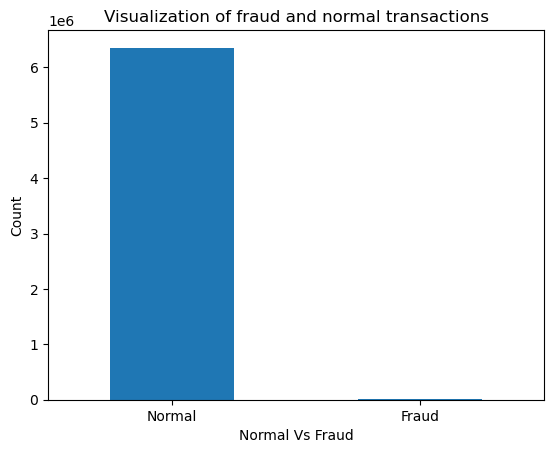

In [143]:
# Visualize
labels = ["Normal", "Fraud"]
count_classes = df.value_counts(df['isFraud'], sort=True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of fraud and normal transactions")
plt.ylabel("Count")
plt.xlabel("Normal Vs Fraud")
plt.xticks(range(2), labels)
plt.show()

As we can see from the figure above, there is an enormous difference between the transactions.

Only 0.13% (8,213) transactions in the dataset are fraudulent indicating hight class imbalance in the dataset. This is important becasue if we build a machine learning model on this highlt skewed data, the non-fraudulent transactions will influence the training of the model almost entirely, thus affecting the results.

## Types of Transactions

In this section, let's explore the dataset by examining the type variable. We present what the different types of transactions are and which of these types can ve fraudulent.

The following plot shows the frequencies of the different transaction types:

In [144]:
type = df["type"].value_counts()
transactions = type.index
quantity = type.values

import plotly.express as px
figure = px.pie(df,
                values=quantity,
                names=transactions,hole=0.5,
                title="Distribution of Transaction type")
figure.show()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


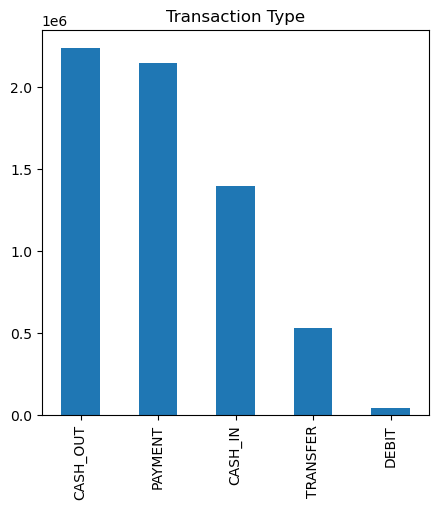

In [199]:
print(df.type.value_counts())

# Visualize the above data
f, ax = plt.subplots(1, 1, figsize=(8,8))
df.type.value_counts().plot(kind='bar', title="Transaction Type", ax=ax, figsize=(5,5))
plt.show()

The most frequent transaction types are CASH-OUT and PAYMENT.

There are 2 flags which stand out to me and it's interesting to look into: isFraud and isFlaggedFrad column. From the data Dictionary, isFraud is the indicator which indicates the actual fraud transactions whereas isFlaggedFraud is what the system prevents the transaction due to some thresholds being trigged.

Let's quickly check what kinds of transaction are being flagged and are fraud.

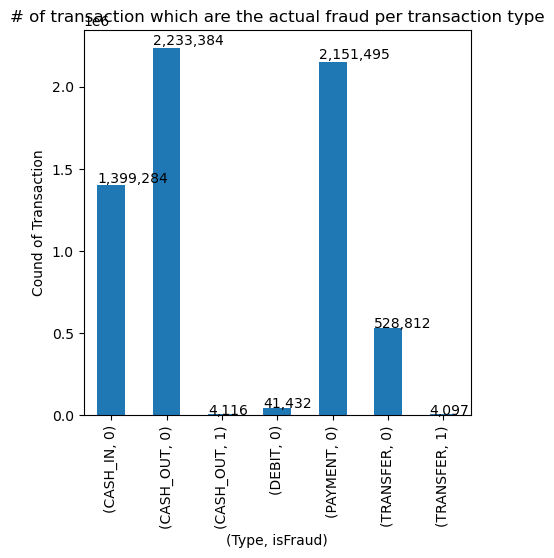

In [197]:
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar', figsize=(5,5))
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Cound of Transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

In [147]:
fraud_df = df[(df["isFraud"] == 1)]
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8213 entries, 2 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            8213 non-null   int64  
 1   type            8213 non-null   object 
 2   amount          8213 non-null   float64
 3   nameOrig        8213 non-null   object 
 4   oldBalanceOrig  8213 non-null   float64
 5   newBalanceOrig  8213 non-null   float64
 6   nameDest        8213 non-null   object 
 7   oldBalanceDest  8213 non-null   float64
 8   newBalanceDest  8213 non-null   float64
 9   isFraud         8213 non-null   int64  
 10  isFlaggedFraud  8213 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 770.0+ KB


In [148]:
non_fraud = len(fraud_df[fraud_df.isFraud == 0])
fraud = len(fraud_df[fraud_df.isFraud == 1])
print(non_fraud)
print(fraud)

0
8213


In [149]:
fraud_df.describe(include=['object'])

,type,nameOrig,nameDest
count,8213,8213,8213
unique,2,8213,8169
top,CASH_OUT,C1305486145,C1193568854
freq,4116,1,2


Only CASH-OUT and TRANSFER transactions can be fraudulent. So, it makes sense to retain only these two types of transactions in our dataset.

And from the above figure, the fraudulent transactions are splitted in an equal percentage.

Therefore, there is an almost equal likelihood that a fraudulent transaction can be CASH_OUT or TRANSFER.

Since only CASH-OUT and TRANSFER transactions can be fraudulent, let's reduce the size of the dataset by retaining only these transaction types and removing PAYMENT, CASH-IN and DEBIT.

In [150]:
new_df = df.loc[df['type'].isin(['CASH_OUT', 'TRANSFER']),:]
print('The new dataframe now has', len(new_df), 'transactions.')

The new dataframe now has 2770409 transactions.


In [151]:
new_df.describe(include=['object'])

,type,nameOrig,nameDest
count,2770409,2770409,2770409
unique,2,2768630,509565
top,CASH_OUT,C724452879,C1286084959
freq,2237500,3,75


We managed to reduce the data from over 6 million transactions to ~2.8 million transactions.

## Data Sanity Checks
### Negative or Zero Transaction Amount
First, let's check if the amount column is always positive. The following two code snippets break this into the number of transactions where the amount is negative and those where the amount is 0.

In [152]:
#Check that there are no negative amounts
print("Number of transactions where the transaction amount is negative: " + str(sum(new_df['amount'] < 0)))

#Check instances where transacted amount is 0
print("Number of transactions where the transaction amount is 0: " + str(sum(new_df['amount'] == 0)))

Number of transactions where the transaction amount is negative: 0
Number of transactions where the transaction amount is 0: 16


In [153]:
trans_0 = new_df[new_df['amount'] == 0]
trans_0

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


There are only a few cases in which transacted amount is 0. We observe by exploring the data of these transactios that they are all fradulent transactions. So, we can assume that if the transaction amount is 0, the transaction is fraudulent.

Let's remove these transactions from the data and include this condition while making the final predictions.

In [154]:
# Remove 0 amount values
new_df = new_df.loc[new_df['amount'] > 0,:]

In [155]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770393 entries, 2 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 253.6+ MB


### Originator's balance and recipient's balance

In this section, let's check if there are any ambiguties in the originator's balance or recipient;s balance.

In [156]:
new_df_count = len(new_df)
orig_initial_balance = len(new_df[new_df.oldBalanceOrig == 0])
print("Percentage of transactions where originator's initial balance is 0: " + str(round((orig_initial_balance/new_df_count)*100, 2)))
dest_final_balance = len(new_df[new_df.newBalanceDest == 0])
print("Percentage of transactions where destination's final balance is 0: " + str(round(dest_final_balance/new_df_count*100, 2)))

Percentage of transactions where originator's initial balance is 0: 47.23
Percentage of transactions where destination's final balance is 0: 0.6


Therefore, in almost half of the transactions, the originator's initial balance was recored as 0. However, in less than 1% of cases, the recipient's final balance was recored as 0.

Ideally, the recipient's final balance should be equal to the reipient's initial balance plus the transaction amount. Similarly, the originator's final balance s hould be equal to originator's initial balance minus the transaction amount.

So, let's check these conditions to see whether the old balance and new balance varialbes are captured accurately for both originator and recipient.

In [157]:
new_df['dest_final_balance'] = new_df['oldBalanceDest'] + new_df['amount']
new_df.head()
new_df['orig_final_balance'] = new_df['oldBalanceOrig'] - new_df['amount']
new_df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,dest_final_balance,orig_final_balance
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.00,0.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,21363.00,0.00
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,234216.94,-213808.94
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,237735.30,-214605.30
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,317952.89,-300850.89


In [158]:
c1 = len(new_df[new_df.newBalanceDest != new_df.dest_final_balance])
print("Transation where destination balance are not accurately captured: "+ str(round(c1/new_df_count*100, 2)))

c2 = len(new_df[new_df.newBalanceOrig != new_df.orig_final_balance])
print("Transactions where originator balances are not accurately captured: " + str(round(c2/new_df_count*100, 2)))

Transation where destination balance are not accurately captured: 42.09
Transactions where originator balances are not accurately captured: 93.72


We can find that in most transactions, the originator's final balance is not accurately captured, and in almost half the cases, the recipient's final balance is not accurately captured.

It could be interesting to see if any of the above discrepancies identified vary between fraudulent transactions and non-fraudulent transactions. This will be done in subsequent sections.

### Balances

In the previous section on Sanity Checks, we noticed that there are inaccuracies in how the balance varialbe is captured for both originator and recipient. We also observed that in alomist half the cases, the originator's initial balance is recored as 0.

In [159]:
fraud_trans = len(new_df[new_df.isFraud == 1])
c3 = len(new_df[(new_df.oldBalanceOrig == 0) & (new_df.isFraud == 1)])
print("% of fraudulent transactions where initial balance of orginator is 0: " + str(round(c3/fraud_trans*100, 2)))

gen_trans = len(new_df[new_df.isFraud == 0])
c4 = len(new_df[(new_df.oldBalanceOrig == 0) & (new_df.isFraud == 0)])
print("% of genuine transactions where initial balance of originator is 0: " + str(round(c4/gen_trans*100, 2)))

% of fraudulent transactions where initial balance of orginator is 0: 0.3
% of genuine transactions where initial balance of originator is 0: 47.37


In fraudulent transactions, originator’s initial balance is 0 only 0.3% of the time as compared to 47% in case of non-fraudulent transactions. This could be another potential differentiator between the two categories.

Let's check the inaccuracy in the balance variable and compare between fraud and nonfraud. The inaccuracy is defined as the difference between what the balance should be accounting for the transaction amount and what it is recorded as balance.

We calculate the balance inaccuracies for both the originator and destination as follows:

In [160]:
new_df['origBalance_inacc'] = (new_df['oldBalanceOrig'] - new_df['amount']) - new_df['newBalanceOrig']
new_df['destBalance_inacc'] = (new_df['oldBalanceDest'] + new_df['amount']) - new_df['newBalanceDest']

In [161]:
new_df.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,dest_final_balance,orig_final_balance,origBalance_inacc,destBalance_inacc
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0,181.00,0.00,0.00,181.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0,21363.00,0.00,0.00,21363.0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0,234216.94,-213808.94,-213808.94,182703.5
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0,237735.30,-214605.30,-214605.30,237735.3
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0,317952.89,-300850.89,-300850.89,-2401220.0


Overall, we identified a few dimensions along which fraudulent transactions can be distinguished from non-fraudulent transactions. These are as follows:
- time step - fraudulent transactions have are equally likely to occur in all time steps, but genuine transactions peak in specific time steps
- balances - initial balance of originator is much more likely to be 0 in case of genuine transactions than fraud transactions
- inaccuracies in balance - inaccuracy in destination balance is likely to be negative in case of genuine transactions but positive in case of fraud transactions

## Predictive Modeling for Fraud Detection

In the previous sections, we identified dimensions that make fraudulent transactions detectable. Based on these results, let's build a supervised classification models.

### Modeling Dataset Creation

Let's choose the variables needed for the ML model, encode categorical varialbes as numberic and standardize the data.

The name of the originator and destination are not needed for classification. So, let's remove them.

In [162]:
new_df = new_df.drop(['nameOrig', 'nameDest','dest_final_balance', 'orig_final_balance', 'isFlaggedFraud'], axis=1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770393 entries, 2 to 6362619
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   step               int64  
 1   type               object 
 2   amount             float64
 3   oldBalanceOrig     float64
 4   newBalanceOrig     float64
 5   oldBalanceDest     float64
 6   newBalanceDest     float64
 7   isFraud            int64  
 8   origBalance_inacc  float64
 9   destBalance_inacc  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 232.5+ MB


Let's see the correlation of the selected datapoints from above.

C:\Users\arthi\AppData\Local\Temp\ipykernel_5832\1355111531.py:9: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\arthi\AppData\Local\Temp\ipykernel_5832\1355111531.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



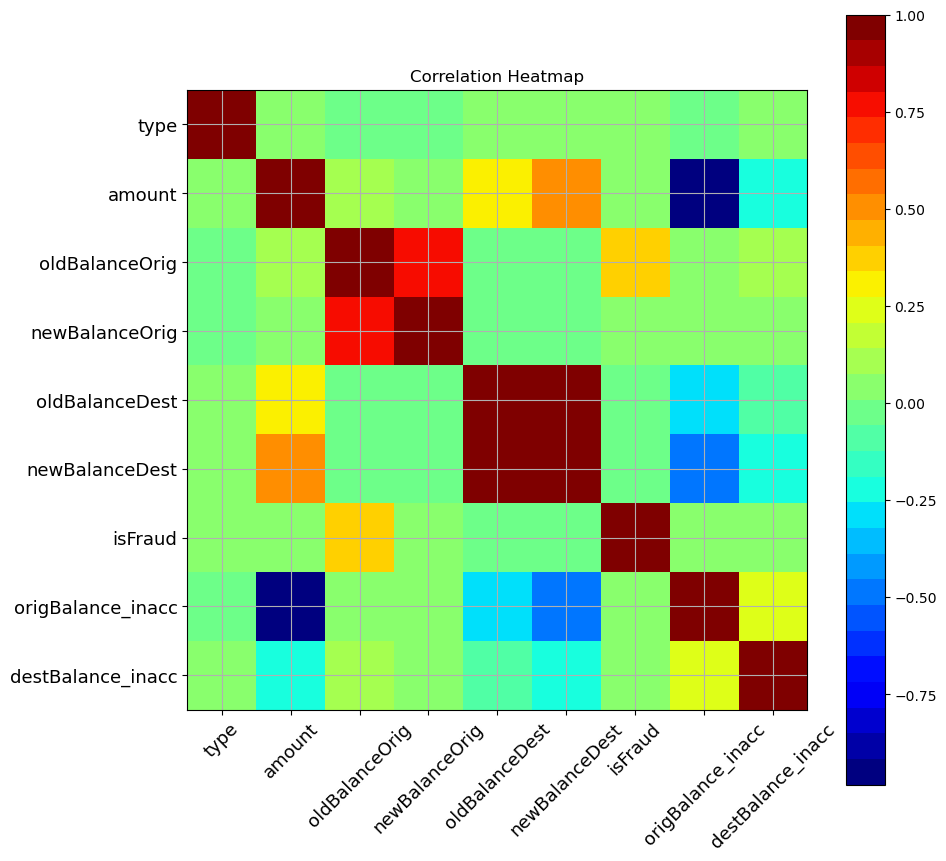

In [163]:
def correlation_plot(df):
    fig = plt.figure(figsize=(10, 10))
    ax1= fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax= ax1.imshow(df.corr(), interpolation = "nearest", cmap = cmap)
    ax1.grid(True)
    plt.title("Correlation Heatmap")
    labels = df.columns.tolist()
    ax1.set_xticklabels(labels, fontsize=13, rotation=45)
    ax1.set_yticklabels(labels, fontsize=13)
    fig.colorbar(cax)
    plt.show()

correlation_plot(new_df)

Based on the dataset, the numeric variables are quite skew, in this case. I'll try to scale it with 2 methods and compare them on the graph.

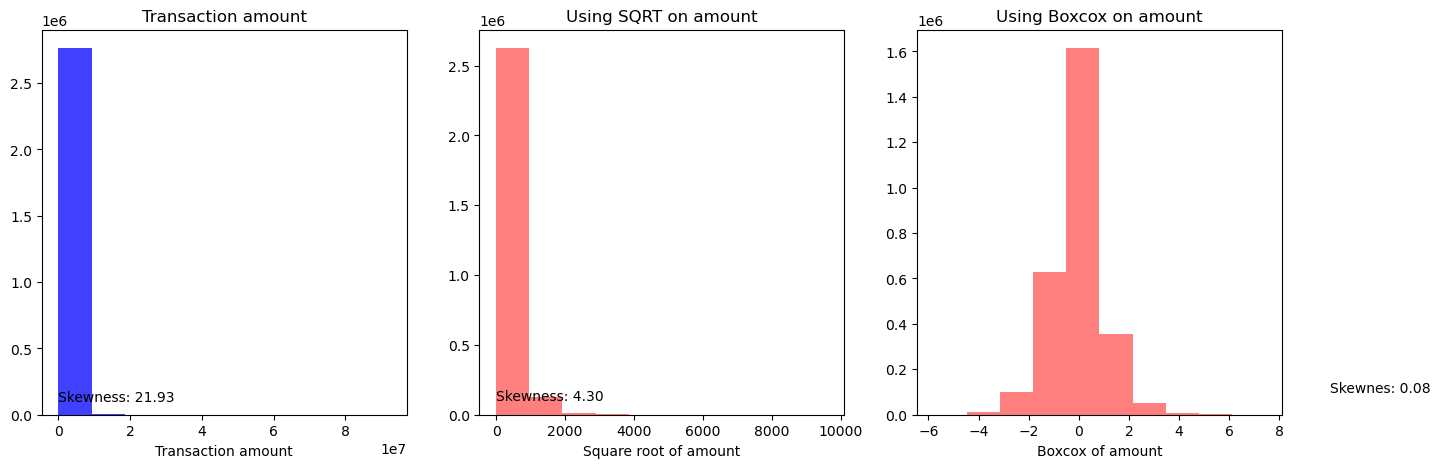

In [164]:
new_df['amount_boxcox'] = preprocessing.scale(boxcox(new_df['amount']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131)
plt.hist(new_df['amount'], facecolor='blue', alpha=0.75)
plt.xlabel("Transaction amount")
plt.title("Transaction amount")
plt.text(10, 100000, "Skewness: {0:.2f}".format(skew(new_df['amount'])))

figure.add_subplot(132)
plt.hist(np.sqrt(new_df['amount']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of amount")
plt.title("Using SQRT on amount")
plt.text(10,100000, "Skewness: {0:.2f}".format(skew(np.sqrt(new_df['amount']))))

figure.add_subplot(133)
plt.hist(new_df['amount_boxcox'], facecolor = "red", alpha=0.5)
plt.xlabel("Boxcox of amount")
plt.title("Using Boxcox on amount")
plt.text(10, 100000, "Skewnes: {0:.2f}".format(skew(new_df['amount_boxcox'])))

plt.show()

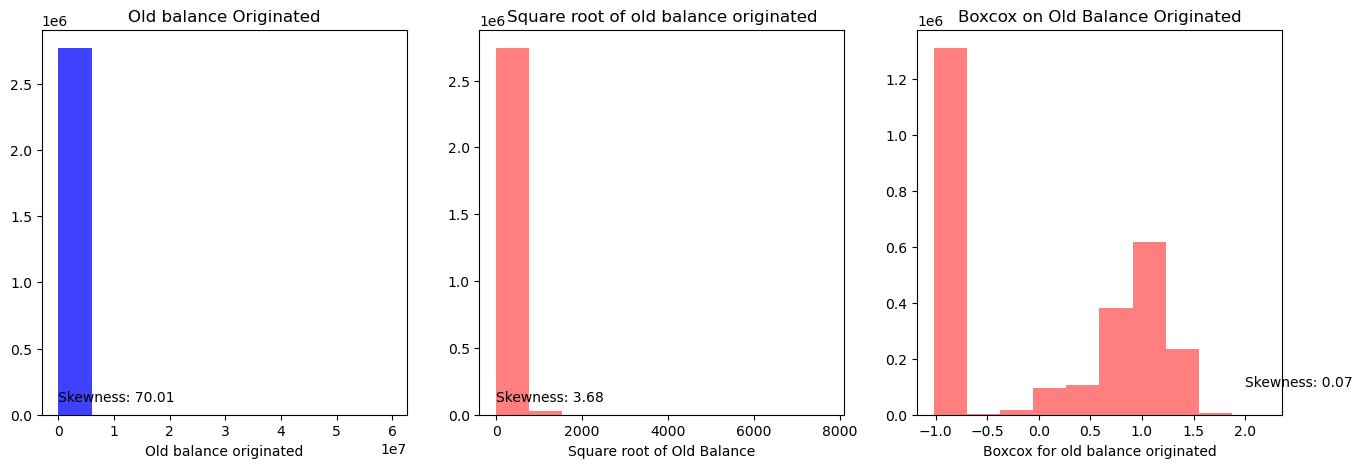

In [165]:
new_df['oldBalanceOrig_boxcox'] = preprocessing.scale(boxcox(new_df['oldBalanceOrig']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131)
plt.hist(new_df['oldBalanceOrig'], facecolor='blue', alpha=0.75)
plt.xlabel('Old balance originated')
plt.title("Old balance Originated")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(new_df["oldBalanceOrig"])))

figure.add_subplot(132)
plt.hist(np.sqrt(new_df['oldBalanceOrig']), facecolor="red", alpha=0.5)
plt.xlabel("Square root of Old Balance")
plt.title("Square root of old balance originated")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(new_df['oldBalanceOrig']))))

figure.add_subplot(133)
plt.hist(new_df['oldBalanceOrig_boxcox'], facecolor = "red", alpha=0.5)
plt.xlabel("Boxcox for old balance originated")
plt.title("Boxcox on Old Balance Originated")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(new_df['oldBalanceOrig_boxcox'])))

plt.show()

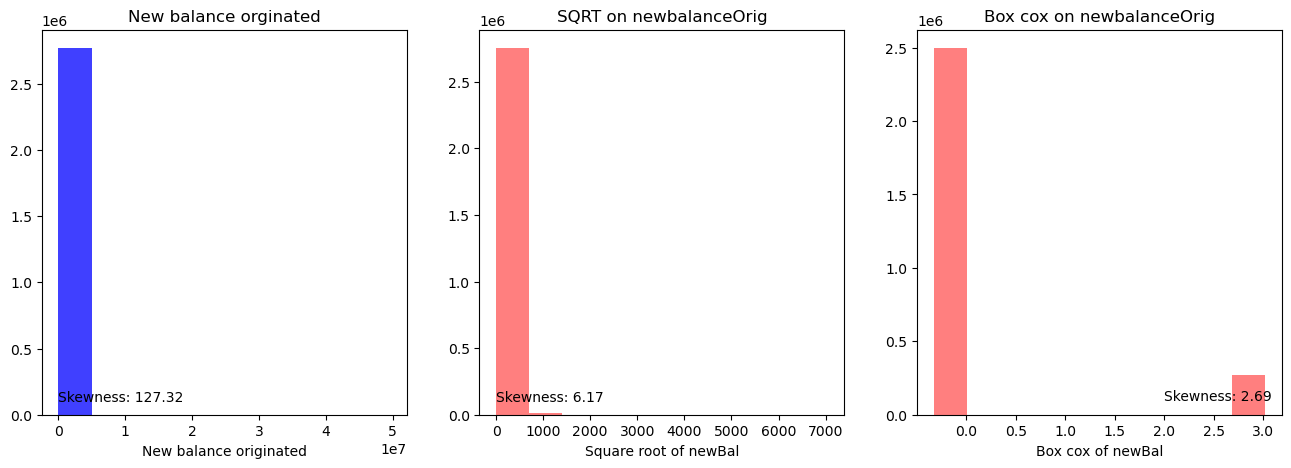

In [166]:
new_df['newbalanceOrg_boxcox'] = preprocessing.scale(boxcox(new_df['newBalanceOrig']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(new_df['newBalanceOrig'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("New balance originated") 
plt.title("New balance orginated") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(new_df['newBalanceOrig'])))


figure.add_subplot(132)
plt.hist(np.sqrt(new_df['newBalanceOrig']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newBal")
plt.title("SQRT on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(new_df['newBalanceOrig']))))

figure.add_subplot(133)
plt.hist(new_df['newbalanceOrg_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newBal")
plt.title("Box cox on newbalanceOrig")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(new_df['newbalanceOrg_boxcox'])))

plt.show()

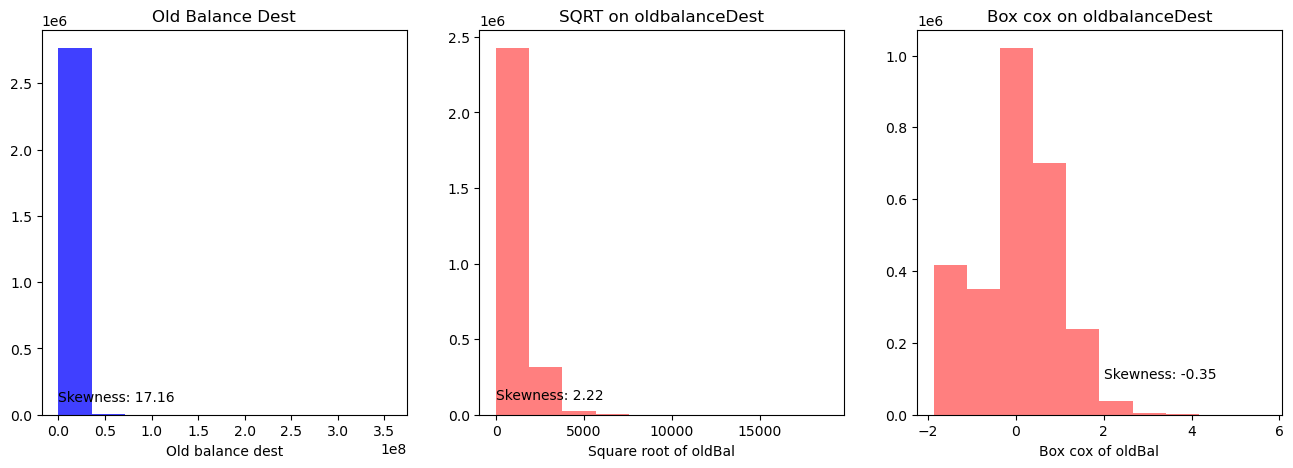

In [167]:
new_df['oldBalanceDest_boxcox'] = preprocessing.scale(boxcox(new_df['oldBalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(new_df['oldBalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("Old balance dest") 
plt.title("Old Balance Dest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(new_df['oldBalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(new_df['oldBalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of oldBal")
plt.title("SQRT on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(new_df['oldBalanceDest']))))

figure.add_subplot(133)
plt.hist(new_df['oldBalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of oldBal")
plt.title("Box cox on oldbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(new_df['oldBalanceDest_boxcox'])))

plt.show()

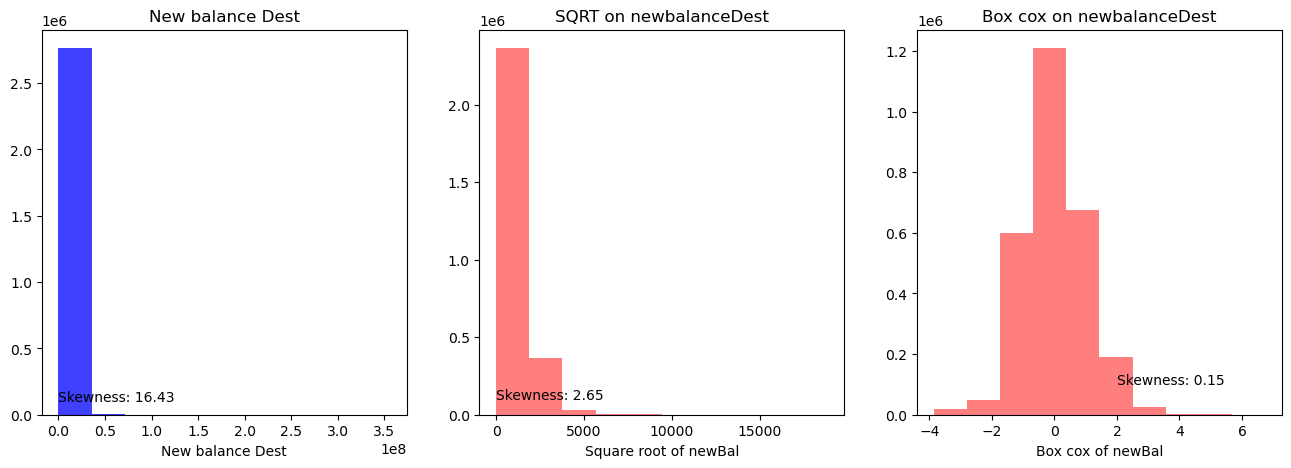

In [168]:
new_df['newBalanceDest_boxcox'] = preprocessing.scale(boxcox(new_df['newBalanceDest']+1)[0])

figure = plt.figure(figsize=(16, 5))
figure.add_subplot(131) 
plt.hist(new_df['newBalanceDest'] ,facecolor='blue',alpha=0.75) 
plt.xlabel("New balance Dest") 
plt.title("New balance Dest") 
plt.text(2,100000,"Skewness: {0:.2f}".format(skew(new_df['newBalanceDest'])))


figure.add_subplot(132)
plt.hist(np.sqrt(new_df['newBalanceDest']), facecolor = 'red', alpha=0.5)
plt.xlabel("Square root of newBal")
plt.title("SQRT on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(np.sqrt(new_df['newBalanceDest']))))

figure.add_subplot(133)
plt.hist(new_df['newBalanceDest_boxcox'], facecolor = 'red', alpha=0.5)
plt.xlabel("Box cox of newBal")
plt.title("Box cox on newbalanceDest")
plt.text(2, 100000, "Skewness: {0:.2f}".format(skew(new_df['newBalanceDest_boxcox'])))

plt.show()

In [169]:
new_df.head()

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,origBalance_inacc,destBalance_inacc,amount_boxcox,oldBalanceOrig_boxcox,newbalanceOrg_boxcox,oldBalanceDest_boxcox,newBalanceDest_boxcox
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,0.00,181.0,-4.099565,0.039552,-0.331129,-1.873358,-3.863425
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,-4.099565,0.039552,-0.331129,-0.917302,-3.863425
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,-213808.94,182703.5,0.288017,0.856866,-0.331129,-1.191655,-1.591635
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,-214605.30,237735.3,0.234390,0.297408,-0.331129,-0.904636,-3.863425
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,-300850.89,-2401220.0,0.558227,0.795600,-0.331129,-1.156123,0.805227


In [170]:
print("The fraud transaction of the filtered dataset: {0:.4f}%".format((len(new_df[new_df.isFraud == 1])/len(new_df))*100))

The fraud transaction of the filtered dataset: 0.2959%


As can be seen, I have already filtered unrelated transaction type out and keep only relevant. There're only actual fraud of 0.3%. This is very imbalance data.

In this notebook, I will quickly use traditional under-sampling method (there are several other ways; under and over sampling, SMOTE, etc).

I will under sample the dataset by creating a 50-50 ratio of randomly selecting 'x' amount of sample from majority class, with 'x' being the total number of records with the minority class.

Also we will use only the boxcox data transformation for prediction.

In [171]:
new_df.drop(["oldBalanceOrig", "newBalanceOrig", "oldBalanceDest", "newBalanceDest", "amount", "type", "origBalance_inacc", "destBalance_inacc", "step"], axis=1, inplace=True)
new_df.head()

,isFraud,amount_boxcox,oldBalanceOrig_boxcox,newbalanceOrg_boxcox,oldBalanceDest_boxcox,newBalanceDest_boxcox
2,1,-4.099565,0.039552,-0.331129,-1.873358,-3.863425
3,1,-4.099565,0.039552,-0.331129,-0.917302,-3.863425
15,0,0.288017,0.856866,-0.331129,-1.191655,-1.591635
19,0,0.234390,0.297408,-0.331129,-0.904636,-3.863425
24,0,0.558227,0.795600,-0.331129,-1.156123,0.805227


In [172]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2770393 entries, 2 to 6362619
Data columns (total 6 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   isFraud                int64  
 1   amount_boxcox          float64
 2   oldBalanceOrig_boxcox  float64
 3   newbalanceOrg_boxcox   float64
 4   oldBalanceDest_boxcox  float64
 5   newBalanceDest_boxcox  float64
dtypes: float64(5), int64(1)
memory usage: 148.0 MB


### Create train and test datasets

let's split the scaled dataset into training and testing datsets. I decided to use 70% of the original data for training and remaining 30% for testing.

Let's do that below

In [173]:
X = new_df.iloc[:, new_df.columns != 'isFraud']
y = new_df.iloc[:, new_df.columns == 'isFraud']

## Addressing Class Imbalance

There are many techniques to address hight-class imbalanced datasets. A few examples are follows - 
1. Undersampling: In this method, random samples from the majority class are deleted so that the class imbalance is more managable.
2. Oversampling: In this method, observations of the minority class are resampled with repetition to increase their presence in the data.
3. SMOTE: This is a type of oversampling, but instead of repeating the observations, it synthesizes new plausible observations of the minority class.

I use undersampling as it is less compulation-intensive. I train the logistic Regression model on a subset of the original training dataset. We retain all the fraud cases and randomly select an equal number of non-fraud cases to create an unsersampled training dataset.

In [174]:
#Number of data points in the minoroity class
number_records_fraud = len(new_df[new_df.isFraud == 1])
fraud_indices = new_df[new_df.isFraud == 1].index.values

# Picking the indices of the normal classes
normal_indices = new_df[new_df.isFraud == 0].index

# Out of the indices we picked, randomly select "x" number (x - same as total fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = new_df.loc[under_sample_indices, :]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'isFraud']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'isFraud']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.isFraud == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.isFraud == 1])/len(under_sample_data))
print("Total number of transactions in resample data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resample data:  16394


## Logistic Regression classifier - Manual Under-Sampling data

From the model evaluation (or confusion matrix), we know that.

1. Accuracy = ( TP + TN ) / Total
2. Presion = TP / ( TP + FP )
3. Recall = TP / (TP + FN )

As such, specifically for this problem, we are interested in the recall score to captue the most fraudulent transactions. As we know, due to the imbalance of the data, many observations could be predicted as False Negatives, being, that we predict a normal transaction, but it is in fact a fraudulent one. Recall captures this.

Obviously, trying to increase recall, trends to come with a decrease of precision. However, in our case, if we predict that a transaction is fraudulent and turs out not to be, is not a massive problem compared to the opposite.

Due to this, many evaluation will be based on recall score.

In [175]:
## Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) 

print("Number of transactions in train dataset: ", format(len(X_train), ",d"))
print("Number of transactions in test dataset: ", format(len(X_test), ",d"))
print("Total number of transactions: ", format(len(X_train)+len(X_test),",d"))

# Undersampled Dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size = 0.3, random_state=0)

print("Number transactions train dataset: ", format(len(X_train_undersample),',d'))
print("Number transactions test dataset: ", format(len(X_test_undersample),',d'))
print("Total number of transactions: ", format(len(X_train_undersample)+len(X_test_undersample),',d'))

Number of transactions in train dataset:  1,939,275
Number of transactions in test dataset:  831,118
Total number of transactions:  2,770,393
Number transactions train dataset:  11,475
Number transactions test dataset:  4,919
Total number of transactions:  16,394


## Let's train a Logistic Regression model using undersampled test and train data which we created above.

In [176]:
label_encoder = LabelEncoder()
y_train_undersample = label_encoder.fit_transform(y_train_undersample.values.ravel())
y_test_undersample = label_encoder.fit_transform(y_test_undersample.values.ravel())

logreg = LogisticRegression()
logreg.fit(X_train_undersample, y_train_undersample)


LogisticRegression()

In [177]:
y_pred = logreg.predict(X_test_undersample)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_undersample, y_test_undersample)))

Accuracy of logistic regression classifier on test set: 0.94


In [178]:
confusion_matrix = confusion_matrix(y_test_undersample, y_pred)
print(confusion_matrix)

[[2286  208]
 [  84 2341]]


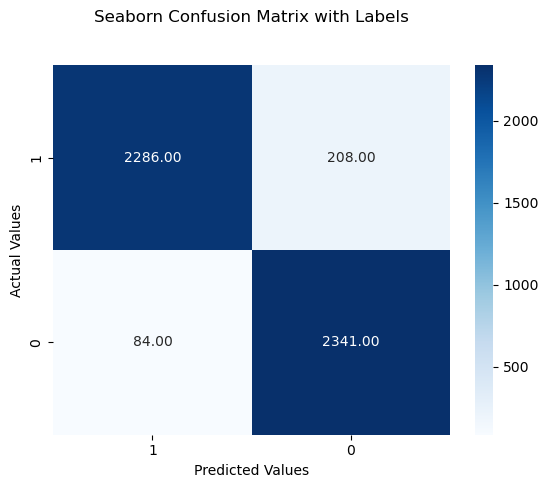

In [179]:
ax = sns.heatmap(confusion_matrix,fmt=".2f", annot=True, cmap="Blues")

ax.set_title('Seaborn Confusion Matrix with Labels\n\n')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

ax.xaxis.set_ticklabels([1,0])
ax.yaxis.set_ticklabels([1,0])

plt.show()

In [180]:
from sklearn.metrics import classification_report
print(classification_report(y_test_undersample, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2494
           1       0.92      0.97      0.94      2425

    accuracy                           0.94      4919
   macro avg       0.94      0.94      0.94      4919
weighted avg       0.94      0.94      0.94      4919



In [181]:
# Logistic regression Classifier Evaluation

lg_acc = accuracy_score(y_test_undersample, y_pred)
lg_prec = precision_score(y_test_undersample, y_pred, average='micro')
lg_rec = recall_score(y_test_undersample, y_pred, average='micro')
lg_f1 = f1_score(y_test_undersample, y_pred, average = 'micro')


print(f"Logistic Regression Accuracy score: {round(lg_acc,2)}")
print(f"Logistic Regression Precision score: {round(lg_prec,2)}")
print(f"Logistic Regression Recall score: {round(lg_rec,2)}")
print(f"Logistic Regression F1 score: {round(lg_f1,2)}")

Logistic Regression Accuracy score: 0.94
Logistic Regression Precision score: 0.94
Logistic Regression Recall score: 0.94
Logistic Regression F1 score: 0.94


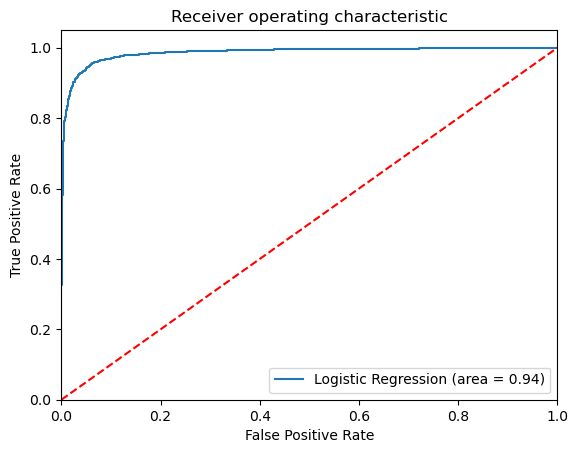

In [182]:
from sklearn.metrics import roc_auc_score, roc_curve

logit_roc_auc = roc_auc_score(y_test_undersample, logreg.predict(X_test_undersample))
fpr, tpr, thresholds = roc_curve(y_test_undersample, logreg.predict_proba(X_test_undersample)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [183]:
# DecisionTree Classifier

from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt_model = dt.fit(X_train_undersample, y_train_undersample)

# Evaluate model
dt_train_pred = dt_model.predict(X_train_undersample)
dt_train_acc = accuracy_score(y_train_undersample, dt_train_pred)
print(f"Accuracy of DecisionTree model from train data : {dt_train_acc}")

Accuracy of DecisionTree model from train data : 1.0


In [184]:
# DecisionTree Classifier Evaluation
dt_pred = dt_model.predict(X_test_undersample)

dt_acc = accuracy_score(y_test_undersample, dt_pred)
dt_prec = precision_score(y_test_undersample, dt_pred, average='micro')
dt_rec = recall_score(y_test_undersample, dt_pred, average='micro')
dt_f1 = f1_score(y_test_undersample, dt_pred, average = 'micro')


print(f"DecisionTree Accuracy score: {round(dt_acc,2)}")
print(f"DecisionTree Precision score: {round(dt_prec,2)}")
print(f"DecisionTree Recall score: {round(dt_rec,2)}")
print(f"DecisionTree F1 score: {round(dt_f1,2)}")

DecisionTree Accuracy score: 0.99
DecisionTree Precision score: 0.99
DecisionTree Recall score: 0.99
DecisionTree F1 score: 0.99


In [186]:
# K-Nearest Neighbors (KNN) Classifier

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_train_undersample, y_train_undersample)

# Evaluate model
knn_train_pred = knn_model.predict(X_train_undersample)
knn_train_acc = accuracy_score(y_train_undersample, knn_train_pred)
print(f"Accuracy of K-Nearest Neighbors model from train data : {knn_train_acc}")


C:\Users\arthi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



Accuracy of K-Nearest Neighbors model from train data : 0.9769063180827887


In [187]:
# K-Nearest Neighbors (KNN) Classifier Evaluation
knn_pred = knn_model.predict(X_test_undersample)

knn_acc = accuracy_score(y_test_undersample, knn_pred)
knn_prec = precision_score(y_test_undersample, knn_pred, average='micro')
knn_rec = recall_score(y_test_undersample, knn_pred, average='micro')
knn_f1 = f1_score(y_test_undersample, knn_pred, average = 'micro')


print(f"K-Nearest Neighbors Accuracy score: {round(knn_acc,2)}")
print(f"K-Nearest Neighbors Precision score: {round(knn_prec,2)}")
print(f"K-Nearest Neighbors Recall score: {round(knn_rec,2)}")
print(f"K-Nearest Neighbors F1 score: {round(knn_f1,2)}")

K-Nearest Neighbors Accuracy score: 0.97
K-Nearest Neighbors Precision score: 0.97
K-Nearest Neighbors Recall score: 0.97
K-Nearest Neighbors F1 score: 0.97


C:\Users\arthi\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



In [189]:
# Random Forest Classifier

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=5, random_state=42)
rf_model = rf.fit(X_train_undersample, y_train_undersample)

# Evaluate model
rf_train_pred = rf_model.predict(X_train_undersample)
rf_train_acc = accuracy_score(y_train_undersample, rf_train_pred)
print(f"Accuracy of K-Nearest Neighbors model from train data : {rf_train_acc}")

Accuracy of K-Nearest Neighbors model from train data : 0.9977342047930283


In [190]:
# Random Forest Classifier Evaluation
rf_pred = rf_model.predict(X_test_undersample)

rf_acc = accuracy_score(y_test_undersample, rf_pred)
rf_prec = precision_score(y_test_undersample, rf_pred, average='micro')
rf_rec = recall_score(y_test_undersample, rf_pred, average='micro')
rf_f1 = f1_score(y_test_undersample, rf_pred, average = 'micro')


print(f"Random Forest Accuracy score: {round(rf_acc,2)}")
print(f"Random Forest Precision score: {round(rf_prec,2)}")
print(f"Random Forest Recall score: {round(rf_rec,2)}")
print(f"Random Forest F1 score: {round(rf_f1,2)}")

Random Forest Accuracy score: 0.98
Random Forest Precision score: 0.98
Random Forest Recall score: 0.98
Random Forest F1 score: 0.98


In [191]:
# Compare score
compare_score = pd.DataFrame({'Score': ['Accuracy', 'Precision', 'Recall','F1']\
                              ,'Logistic Regression': [round(lg_acc,2),round(lg_prec,2),round(lg_rec,2),round(lg_f1,2)]\
                              ,'DecisionTree': [round(dt_acc,2),round(dt_prec,2),round(dt_rec,2),round(dt_f1,2)]\
                             ,'KNN': [round(knn_acc,2),round(knn_prec,2),round(knn_rec,2),round(knn_f1,2)]\
                             ,'Random Forest': [round(rf_acc,2),round(rf_prec,2),round(rf_rec,2),round(rf_f1,2)]})
compare_score

,Score,Logistic Regression,DecisionTree,KNN,Random Forest
0,Accuracy,0.94,0.99,0.97,0.98
1,Precision,0.94,0.99,0.97,0.98
2,Recall,0.94,0.99,0.97,0.98
3,F1,0.94,0.99,0.97,0.98


# Analysis Summary

I analyzed the financial transactions data and developed a machine learning model to detect fraud. The analysis included data cleaning, exploratory analysis and predictive modeling.

In the data cleaning, I checked for missing values, columns names and summarized the variables in the data.

In the EDA process, I have found that the transactions which are fraud are mostly 'Cash-Out' and 'Transfer'.

In the predictive modelling process, I have found the imbalance in the dataset and used under-sampling method to balance the dataset.

Later I performed classification models on the dataset and the accuracy, F1, recall and precision scores of the models. It is found that the Decision Tree classification model has the highest accuracy of 0.99 when compared to other models.





References - 
- Dataset refernce:  https://www.kaggle.com/datasets/ealaxi/paysim1
- https://www.projectpro.io/article/credit-card-fraud-detection-project-with-source-code-in-
- https://towardsdatascience.com/credit-card-fraud-detection-using-machine-learning-python-5b098d4a8edc
- https://data-flair.training/blogs/credit-card-fraud-detection-python-machine-learning/

# Thank you